In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

### Load data and visualize some rows

In [2]:
graph = pd.read_csv('q1_data.csv', index_col=0)
graph.head(3)

,Mexico City,Sofia,Caracas,Paris,Oslo,Panama,Riga,Hanoi,Athens,Luxembourg,...,Santo Domingo,London,Andorra la Vella,Yerevan,Madrid,Amsterdam,Copenhagen,Lima,Vilnius,Warsaw
Mexico City,0.000000,10943.249595,3597.018894,9196.121646,9195.632410,2407.509542,10027.336535,14759.958516,11280.399674,9417.091543,...,3062.375170,8928.820398,9393.135021,12392.218540,9062.613574,9215.541204,9509.162920,4255.032976,10240.684649,10180.162850
Sofia,10943.249595,0.000000,9235.562797,1757.561532,2096.229362,10360.411414,1585.325302,7847.187565,525.673837,1526.175436,...,8887.495567,2014.605290,1779.664110,1783.484275,2253.345327,1744.422812,1637.012112,11753.661475,1340.976711,1073.949136
Caracas,3597.018894,9235.562797,0.000000,7616.652180,8311.079762,1395.108255,9091.109074,16421.894156,9343.995782,7899.810067,...,951.601568,7496.409509,7456.263338,11009.217933,6992.114712,7851.614143,8385.224076,2744.751040,9195.400241,8944.692095


Here we see, for example, that from Sofia to Paris there are 1757 km.

### Plot graph

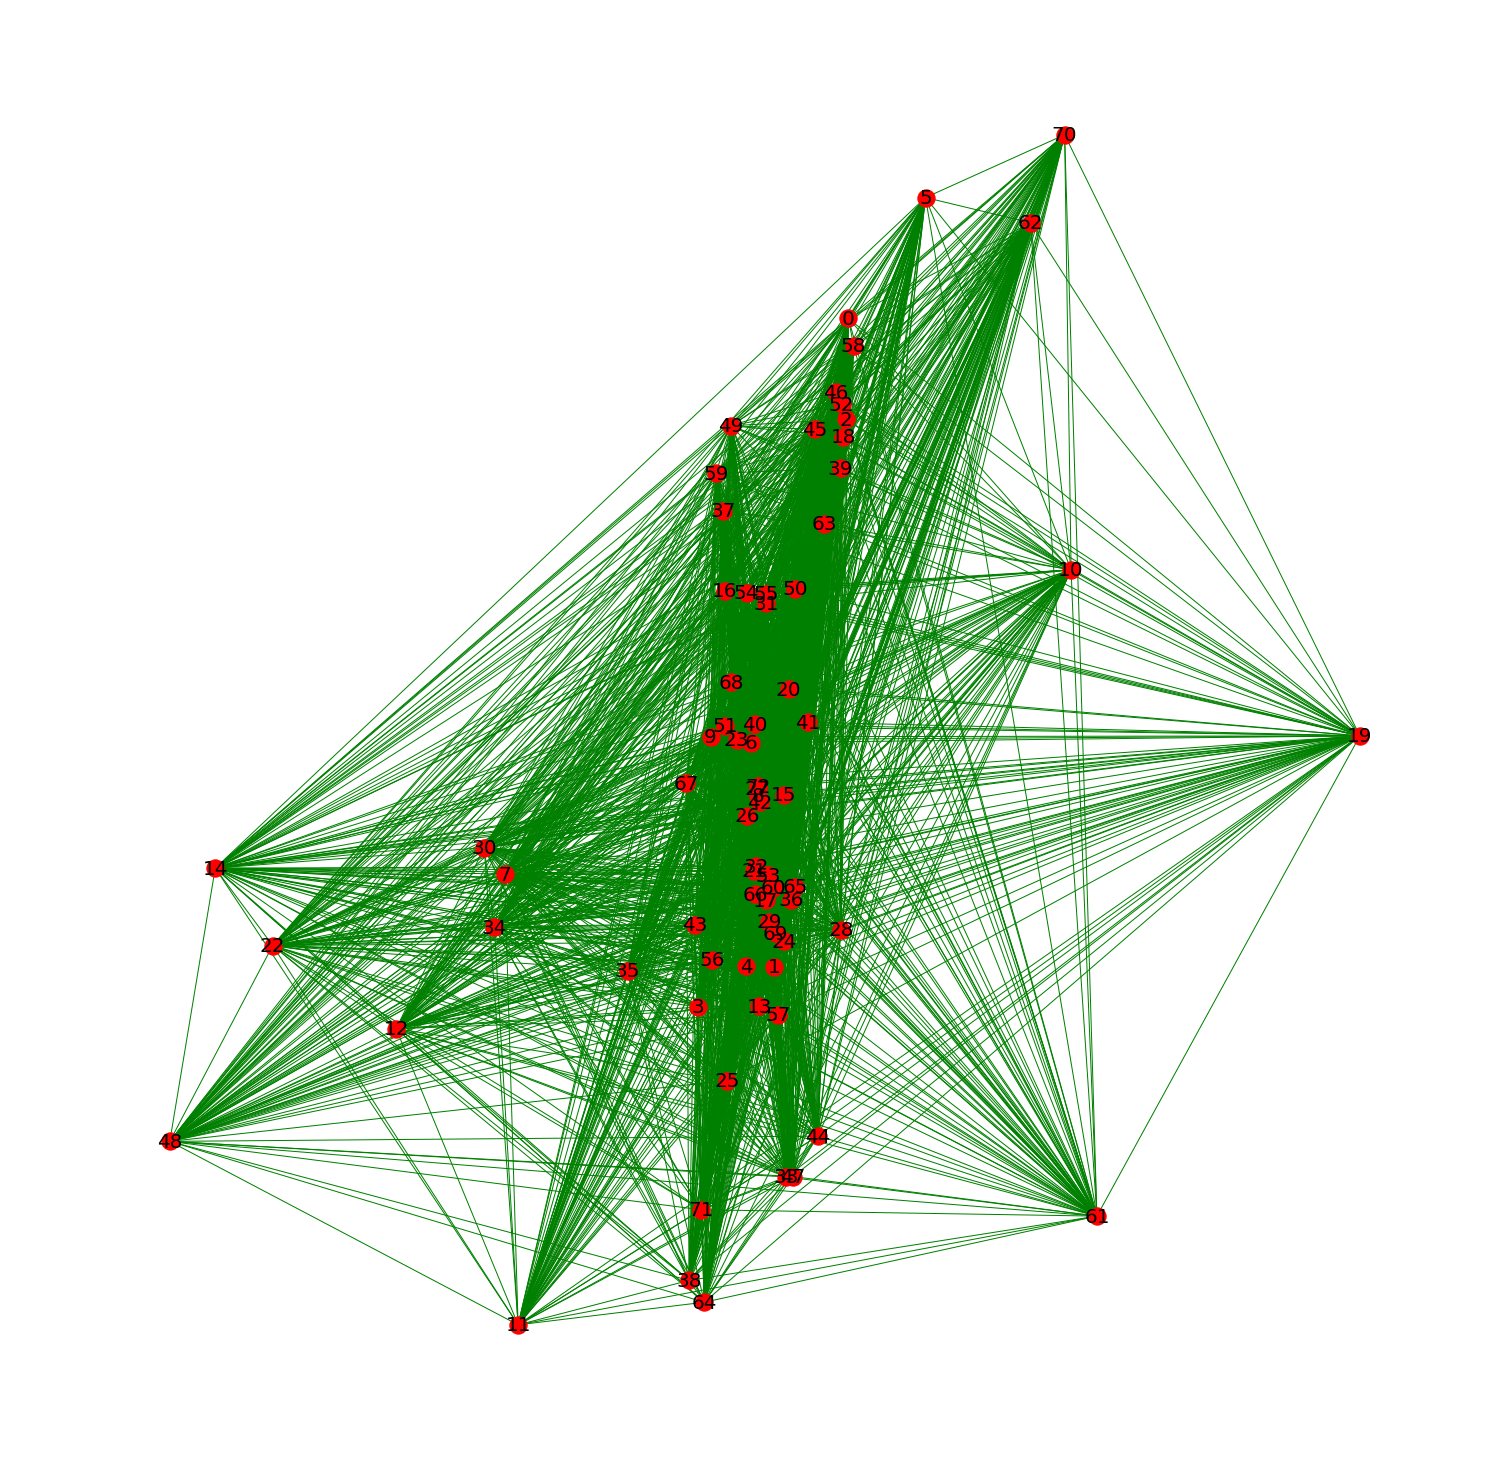

In [3]:
G = nx.from_numpy_matrix(graph.values)
nx.draw(G, with_labels=True, font_size=20, edge_color='g')
labels = nx.get_edge_attributes(G,'weight')
plt.draw()

In this case, the graph is not really useful since points are in a 3D coodinate system but we are
projecting them onto a 2D space. But it's a nice a picture, isn't it? You can use this code to represent a graph in the future. Notice that the nodes (cities) are identified by numbers, but I'm not going to conjecture anything about the graph, because of the projection issue.

### Function to find shortest node from current

A really simple policy to decide next destination for a reindeer is as follows: given its position, and the visited cities, we will decide the next move to be the non-visited closest city based on graph distances.

In [4]:
def find_shortest_node(cur, visited, graph):
    distances = graph.sort_values()
    i = 0
    while distances.index[i] in visited:
        i += 1
    return distances.index[i], graph.loc[distances.index[i]]

### Distance-based method

Based on previous function, let's iterate through reindeers and build the first end-to-end algorithm.

In [5]:
city2node = {i: ind for ind,i in enumerate(graph.columns)}
node2city = {ind:i for ind,i in enumerate(graph.columns)}
current = {i: city2node['North Pole'] for i in range(8)}
visited = {city2node['North Pole']}
paths = {i : list() for i in range(8)}
distances = [0] * 8
graph.columns = range(len(graph.columns))
graph.index = range(len(graph.columns))

In [7]:
while len(visited) < len(city2node):
    min_travelled = 1000000000
    for i in range(8):
        next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
        if distances[i] + dist < min_travelled:
            min_travelled = distances[i] + dist
            dist_agent = dist
            agent = i
            next_node = next_node_i
    paths[agent].append(node2city[next_node])
    distances[agent] += dist_agent
    visited.update({next_node})
    current[agent] = next_node

print('Speed: {} kmph'.format(max(distances)/10))
for i in paths:
    print(' -> '.join(paths[i]))

Speed: 2350.3072558947 kmph
Oslo -> Amsterdam -> Brussels -> Luxembourg -> Bern -> Madrid -> Ottawa -> Mexico City -> Santiago
Tallinn -> Kiev -> Yerevan -> Baku -> Tehran -> Ashgabat -> Tashkent -> Kabul -> Hanoi -> Taipei
Stockholm -> Warsaw -> Budapest -> Sarajevo -> Valletta -> Pretoria -> Montevideo
Riga -> Belgrade -> Skopje -> Athens -> Colombo -> Jakarta -> Canberra -> Wellington
Moscow -> Ankara -> Nicosia -> Damascus -> New Delhi -> Bangkok -> Manila
Copenhagen -> Berlin -> Prague -> Ljubljana -> Zagreb -> Rome -> Santo Domingo -> Caracas -> Bogota -> Quito -> Lima -> Sucre -> Asuncion -> Buenos Aires
Vilnius -> Bucharest -> Sofia -> Cairo -> Beijing -> Seoul -> Tokyo
Dublin -> London -> Paris -> Andorra la Vella -> Lisbon -> Washington -> Tegucigalpa -> San Jose -> Panama -> Brasilia


Notice that we iterate along all reindeers, select the one that travels the less, and start again until all cities are visited.

### Zone-based method

Analyzing the previous results, we see that there is a reindeer starting in Stockholm and finishing in Montevideo. This does not make sense: it is better that reindeers specialize somehow in a zone rather than travelling along the whole globe. An interesting idea could be the following: divide the map in 8 zones and make each reindeer responsible of one zone.

#### Divide map in zones

This is an easy exercise of clustering. When I started experimenting my idea was to send each reindeer to the centroid of each cluster. Therefore, we cannot use the well-known K-means because the centroid needs to be a city. A good alternative for this is [K-medoids](https://en.wikipedia.org/wiki/K-medoids). Moreover, the [implementation](https://github.com/letiantian/kmedoids) in Python of K-medoids allows feeding the algorithm with a distance matrix, so our data is ready to use. Using SKlearn K-means could be an interesting line of future work.

In [15]:
from kmedoids import kMedoids
M, C = kMedoids(graph.values, k=8)
for i in C:
    print("{}: {}".format(i,list(map(lambda x: node2city[x],C[i]))))

0: ['Oslo', 'Tallinn', 'North Pole', 'Stockholm', 'Copenhagen']
1: ['Hanoi', 'Bangkok', 'Manila', 'Seoul', 'Beijing', 'Tokyo', 'Jakarta', 'Wellington', 'Canberra', 'Taipei']
2: ['Ljubljana', 'Zagreb', 'Valletta', 'Rome', 'Andorra la Vella']
3: ['Paris', 'Luxembourg', 'Lisbon', 'Berlin', 'Brussels', 'Dublin', 'Bern', 'Prague', 'London', 'Madrid', 'Amsterdam']
4: ['Kabul', 'Tashkent', 'Tehran', 'Colombo', 'New Delhi', 'Ashgabat', 'Baku', 'Yerevan']
5: ['Mexico City', 'Caracas', 'Panama', 'Montevideo', 'Tegucigalpa', 'Santiago', 'Buenos Aires', 'Brasilia', 'Asuncion', 'Sucre', 'San Jose', 'Ottawa', 'Quito', 'Bogota', 'Washington', 'Santo Domingo', 'Lima']
6: ['Sofia', 'Athens', 'Damascus', 'Nicosia', 'Ankara', 'Skopje', 'Budapest', 'Sarajevo', 'Pretoria', 'Bucharest', 'Belgrade', 'Cairo']
7: ['Riga', 'Kiev', 'Moscow', 'Vilnius', 'Warsaw']


#### Distribute reindeers per zones

In the first iteration we send each reindeer to one different zone. Note that we need to reload variables

In [16]:
M, C = kMedoids(graph.values, k=8)
current = {i: city2node['North Pole'] for i in range(8)}
visited = {city2node['North Pole']}
paths = {i : list() for i in range(8)}
distances = [0] * 8

for i in range(8):
    next_node, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
    paths[i].append(node2city[next_node])
    distances[i] += dist
    visited.update({next_node})
    current[i] = next_node

while len(visited) < len(city2node):
    min_travelled = 1000000000
    for i in range(8):
        next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
        if distances[i] + dist < min_travelled:
            min_travelled = distances[i] + dist
            dist_agent = dist
            agent = i
            next_node = next_node_i
    paths[agent].append(node2city[next_node])
    distances[agent] += dist_agent
    visited.update({next_node})
    current[agent] = next_node

print('Speed: {} kmph'.format(max(distances)/10))
for i in paths:
    print(' -> '.join(paths[i]))

Speed: 2254.7100953912 kmph
Oslo -> Stockholm -> Tallinn -> Riga -> Vilnius -> Warsaw -> Berlin -> Prague -> Budapest -> Zagreb -> Ljubljana -> Sarajevo -> Belgrade -> Skopje -> Sofia -> Bucharest -> Athens -> Ankara -> Kiev -> Moscow -> Copenhagen -> Amsterdam -> London -> Dublin
Baku -> Yerevan -> Tehran -> Ashgabat -> Damascus -> Nicosia -> Cairo -> Valletta -> Rome -> Bern -> Luxembourg -> Brussels -> Paris -> Andorra la Vella -> Madrid -> Lisbon
Sucre -> Asuncion -> Buenos Aires -> Santiago
Beijing -> Seoul -> Tokyo -> Taipei -> Manila -> Hanoi -> Pretoria
Brasilia -> Montevideo -> Lima
Canberra -> Wellington
Ottawa -> Washington -> Santo Domingo -> Caracas -> Bogota -> Quito -> Panama -> San Jose -> Tegucigalpa -> Mexico City
Tashkent -> Kabul -> New Delhi -> Colombo -> Bangkok -> Jakarta


We have sent the reindeers one to each zone, but after that is possible that they move back to the closest zone to the North Pole, so eventually having the same problem again. One interesting idea is to force the reindeers to move along its assigned zone until completing all nodes in it.

In [27]:
M, C = kMedoids(graph.values, k=8)
current = {i: city2node['North Pole'] for i in range(8)}
visited = {city2node['North Pole']}
paths = {i : list() for i in range(8)}
distances = [0] * 8

for i in range(8):
    next_node, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
    paths[i].append(node2city[next_node])
    distances[i] += dist
    visited.update({next_node})
    current[i] = next_node

while len(visited) < len(city2node):
    min_travelled = 1000000000
    for i in range(8):
        if all([v in visited for v in C[i]]):
            next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
        else: # finish your zone before helping others
            next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
        if distances[i] + dist < min_travelled:
            min_travelled = distances[i] + dist
            dist_agent = dist
            agent = i
            next_node = next_node_i
    paths[agent].append(node2city[next_node])
    distances[agent] += dist_agent
    visited.update({next_node})
    current[agent] = next_node

print('Speed: {} kmph'.format(max(distances)/10))
for i in paths:
    print(' -> '.join(paths[i]))

Speed: 1934.0230497204 kmph
Ottawa -> Washington -> Santo Domingo -> Caracas -> Bogota -> Quito -> Brasilia
Beijing -> Seoul -> Tokyo -> Taipei -> Manila -> Hanoi -> Bangkok -> Jakarta -> Colombo
Lima -> Sucre -> Asuncion -> Buenos Aires -> Montevideo
Kiev -> Bucharest -> Sofia -> Skopje -> Belgrade -> Sarajevo -> Zagreb -> Ljubljana -> Budapest -> Prague -> Bern -> Andorra la Vella -> Madrid -> Lisbon -> Rome -> Valletta
Canberra -> Wellington
Mexico City -> Tegucigalpa -> San Jose -> Panama -> Santiago
Tashkent -> Kabul -> Ashgabat -> Tehran -> Baku -> Yerevan -> Ankara -> Nicosia -> Damascus -> Cairo -> Pretoria
Oslo -> Stockholm -> Tallinn -> Riga -> Vilnius -> Warsaw -> Berlin -> Copenhagen -> Amsterdam -> Brussels -> Luxembourg -> Paris -> London -> Dublin -> Moscow -> Athens -> New Delhi


### Initialization matters

It is worth pointing out that the clustering algorithm is not deterministic. It depends on its initialization, and in turn, it has an impact on the performance of next steps:
- This can be observed if we execute the last block several times: different results are obtained.
- Also, we can see that in some cases the algorithm crashes. This occurs when the North Pole is assigned a cluster itself. Since we are sending a reindeer to this cluster, but the only single node in it has been visited, the algorithm as it is does not work. 

So hereafter there is the last version of the algorithm taking into account this, such that:
- North Pole is not used for clustering.
- 200 iterations of the algorithm are run, and the output is the best of those operations, where the difference among all those iterations is the cluster algorithm initialization.

In [28]:
minval = 4000
graph = pd.read_csv('q1_data.csv', index_col=0)
indNorthPole = [ind for ind,i in enumerate(graph.columns) if i == 'North Pole'][0]
cols = list(range(indNorthPole)) + list(range(indNorthPole+1, len(graph))) + [indNorthPole]
graph = graph.iloc[cols,cols]
city2node = {i: ind for ind,i in enumerate(graph.columns)}
node2city = {ind:i for ind,i in enumerate(graph.columns)}
graph.columns = range(len(graph))
graph.index = range(len(graph))

for it in range(1,200):
    M, C = kMedoids(graph.iloc[:-1,:-1].values, k=8)
    current = {i: city2node['North Pole'] for i in range(8)}
    visited = {city2node['North Pole']}
    paths = {i : list() for i in range(8)}
    distances = [0] * 8

    for i in range(8):
        next_node, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
        paths[i].append(node2city[next_node])
        distances[i] += dist
        visited.update({next_node})
        current[i] = next_node

    while len(visited) < len(city2node):
        min_travelled = 1000000000
        for i in range(8):
            if all([v in visited for v in C[i]]):
                next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], :])
            else: # finish your zone before helping others
                next_node_i, dist = find_shortest_node(current[i], visited, graph.iloc[current[i], C[i]])
            if distances[i] + dist < min_travelled:
                min_travelled = distances[i] + dist
                dist_agent = dist
                agent = i
                next_node = next_node_i
        paths[agent].append(node2city[next_node])
        distances[agent] += dist_agent
        visited.update({next_node})
        current[agent] = next_node
    tmp = max(distances)/10
    if tmp < minval:
        minval = tmp
        minpaths = paths
        print(tmp)
        
print('Speed: {} kmph'.format(minval))
for i in minpaths:
    print(' -> '.join(minpaths[i]))

2372.39329872
2075.33687
2061.09365841
1854.00817298
1776.55611721
1720.09690112
1665.42562055
Speed: 1665.4256205544 kmph
Dublin -> London -> Brussels -> Amsterdam -> Luxembourg -> Paris -> Bern -> Andorra la Vella -> Madrid -> Lisbon -> Brasilia
Oslo -> Stockholm -> Tallinn -> Riga -> Vilnius -> Warsaw -> Berlin -> Copenhagen -> Kiev -> Moscow -> Ankara -> New Delhi -> Colombo
Prague -> Budapest -> Zagreb -> Ljubljana -> Sarajevo -> Belgrade -> Skopje -> Sofia -> Bucharest -> Athens -> Valletta -> Rome -> Pretoria
Tashkent -> Kabul -> Ashgabat -> Tehran -> Baku -> Yerevan -> Damascus -> Nicosia -> Cairo
Canberra -> Wellington
Santo Domingo -> Caracas -> Bogota -> Quito -> Lima -> Sucre -> Asuncion -> Buenos Aires -> Montevideo
Beijing -> Seoul -> Tokyo -> Taipei -> Manila -> Hanoi -> Bangkok -> Jakarta
Ottawa -> Washington -> Mexico City -> Tegucigalpa -> San Jose -> Panama -> Santiago


And we have got the best solution overall, forcing each reindeer to travel at most at 1625 kmph.

### Check the solution

Finally, just check the speed required by each reindeer by summing up the distance moved and dividing by the 10 hours they have to distribute the presents.

In [106]:
for i in minpaths:
    distance = 0
    current = city2node['North Pole']
    for j in minpaths[i]:
        distance += graph.loc[current, city2node[j]]
        current = city2node[j]
    print(distance/10)

1153.35693483
1720.09690112
1625.70517399
1480.46545108
1600.72616671
1205.2264646
1582.87191227
1476.92909603
